In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [92]:
def cost_to_prob(cost):
    return np.exp(cost * -1)

In [113]:
def eval_auc(df, TI_only=False):
    df['Prob'] = df.apply(lambda row: [cost_to_prob(c) for c in eval(row['Costs'])], axis=1)
    df['auc'] = df.apply(lambda row: get_auc(row, TI_only=TI_only), axis=1)
    return df

def get_auc(row, TI_only=False):
    ys = eval(row['IsLicit'])
    pred = (row['Prob'])
    TI = eval(row['IsTI'])
    if TI_only:
        filtered = [(y, p, t) for (y, p, t) in zip(ys, pred, TI) if t == 1]
        ys = [f[0] for f in filtered]
        pred = [f[1] for f in filtered]
    fpr, tpr, thresholds = metrics.roc_curve(ys, pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
#     plot_roc = True if row['Step'] == 74 else False
    
    plot_roc=False
    if plot_roc:
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name='example estimator')
        display.plot()
        plt.title(f"{row['Strategy']}; step {row['Step']}")
        plt.show()
        
        print("probs:", np.array(pred).round(3))
        print("ys:", ys)
        print("thresholds:", thresholds)

    return roc_auc
    
def plot_auc_fancy(df, TI_only=False, title=None):
    df = eval_auc(df, TI_only=TI_only)
    
    from scipy.stats import sem

    # create a pivot table to calculate mean and standard deviation of auc by Step and Strategy
    pivot_df = df.pivot_table(values='auc', index='Step', columns='Strategy', aggfunc=[np.mean, sem])

    # get the mean auc and standard deviation values for each Strategy
    means = pivot_df['mean']
    stds = pivot_df['sem']

    # set up the plot
    plt.figure(figsize=(8, 4))

    # plot the mean auc for each Strategy with shaded error bars
    for col in means.columns:
        plt.plot(means.index, means[col], label=col, alpha=0.8, linewidth=2)
        plt.fill_between(means.index, means[col] - stds[col], means[col] + stds[col], alpha=0.2)

    # set plot title and axis labels
    plt.title('Mean AUC by Strategy')
    plt.xlabel('Step')
    plt.ylabel('Mean AUC')

    # add legend and grid
    plt.legend()
    
    if title is not None:
        plt.title(title)
    
    plt.ylim(0.6, 1.0)

    # display the plot
    plt.show()
    
def plot_auc(df, TI_only=False, title=None):
    df = eval_auc(df, TI_only=TI_only)
    # group by Strategy and Step, and compute mean and standard deviation of auc
    grouped = df.groupby(['Strategy', 'Step'])['auc'].agg(['mean', 'std']).reset_index()

    # plot mean auc as a function of Step, with error bars for the standard deviation
    for strategy, data in grouped.groupby('Strategy'):
        plt.errorbar(data['Step'], data['mean'], yerr=data['std'], label=strategy)

    # add axis labels and legend
    plt.xlabel('Step')
    plt.ylabel('Mean AUC')
    plt.legend()
    
#     plt.ylim(0.6, 1.0)

    if title is not None:
        plt.title(title)
    
    # show the plot
    plt.show()

In [215]:
import os
exp = "batch_prior=0.2"
experiment_dir = os.path.join("/raid/lingo/alexisro/lm-informants/results", exp)

/raid/lingo/alexisro/anaconda3/envs/pedagogy/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/raid/lingo/alexisro/anaconda3/envs/pedagogy/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


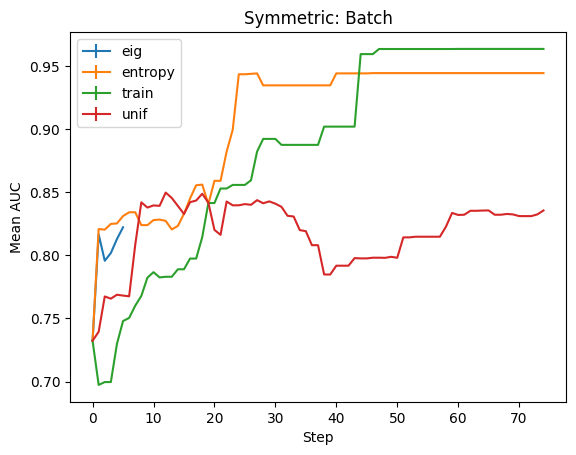

In [248]:
df = pd.read_csv(f'{experiment_dir}/BroadHoldoutEvals.csv')
# df = df.query("Run == 0 and Strategy == 'entropy'")
plot_auc(df[df['N_INIT']==0], title="Symmetric: Batch")

/raid/lingo/alexisro/anaconda3/envs/pedagogy/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/raid/lingo/alexisro/anaconda3/envs/pedagogy/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


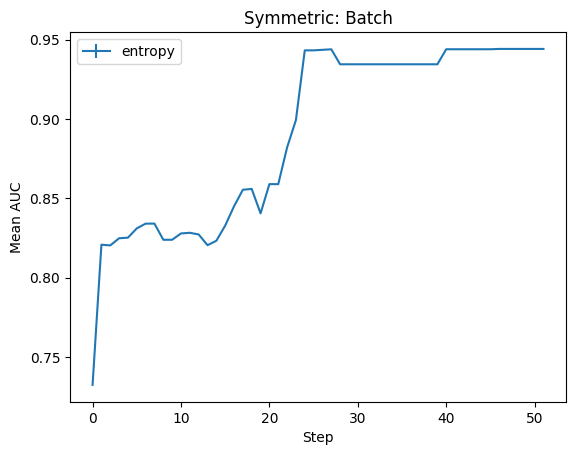

In [221]:
df = pd.read_csv(f'{experiment_dir}/BroadHoldoutEvals.csv')
# df = df.query("Run == 0 and Strategy == 'entropy'")
plot_auc(df[df['N_INIT']==0], title="Symmetric: Batch")

In [146]:
unique_features = pd.read_csv('all_features_in_data_unique.csv')['X1'].unique()

In [111]:
df = pd.read_csv(f'{experiment_dir}/FeatureProbs.csv')
df = df.query("Run == 0 and Strategy == 'unif'")

# Define a function to update the plot based on the selected step
def update(step):
    # Filter the dataframe to only include rows with the selected step
    filtered_df = df[df['Step'] == step]
    
    filtered_df = filtered_df[filtered_df['feature'].isin(unique_features)]
    
    
    # Group the data by feature and calculate the mean cost for each feature
    grouped_df = filtered_df.groupby('feature').mean()
    
    plt.figure(figsize=(20, 5))
    
    # Create the plot
    plt.clf()
    plt.plot(grouped_df['cost'], linestyle='None', marker='o', markersize=3)
    plt.xlabel('Feature')
    plt.xticks(rotation=90)
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Cost')
    plt.title('Cost vs Feature for Step {}'.format(step))
    plt.show()

# Create the interactive widget
from ipywidgets import interact
interact(update, step=(0, df['Step'].max()))

ValueError: value must be between min and max (min=0, value=nan, max=nan)

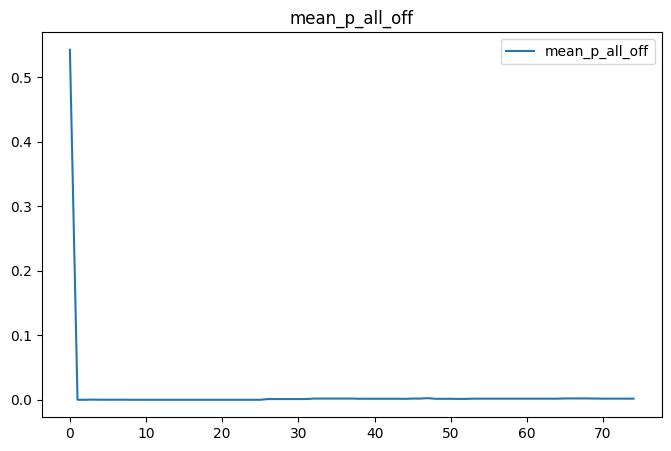

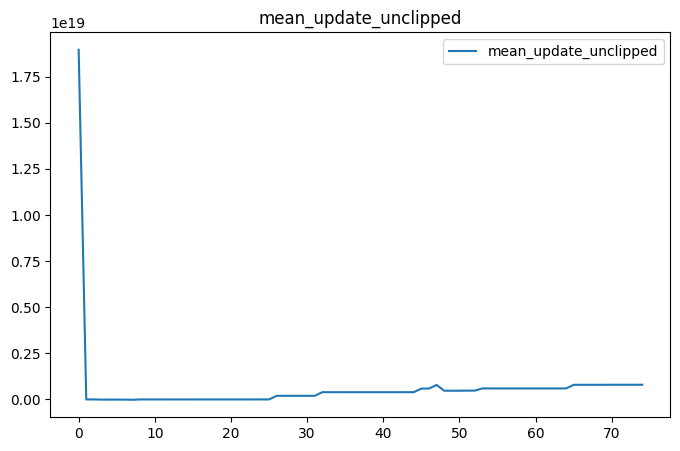

In [106]:
from ast import literal_eval

df = pd.read_csv(f'{experiment_dir}/ResultsByObservations.csv')
df = df.query("Run == 0 and strategy == 'unif'")
# display(df['p_all_off'].sample().values)
# df['log_p_others'] = df.log_p_others.apply(lambda x: literal_eval(str(x)))
# df['mean_log_p_others'] = df.log_p_others.apply(lambda x: np.mean(literal_eval(str(x))))
# df['mean_p_others'] = df.p_others.apply(lambda x: np.mean(literal_eval(str(x))))
df['update_unclipped'] = df.update_unclipped.apply(lambda x: literal_eval(str(x)))
# df['update_clipped'] = df.update_clipped.apply(lambda x: literal_eval(str(x)))
df['p_all_off'] = df.p_all_off.apply(lambda x: literal_eval(str(x)))
df['mean_update_unclipped'] = df.update_unclipped.apply(lambda x: np.mean(literal_eval(str(x))))
df['mean_p_all_off'] = df.p_all_off.apply(lambda x: np.mean(literal_eval(str(x))))
df['steps'] = df.apply(lambda row: [row['Step'] for _ in range(len(row['p_all_off']))], axis=1)

fig = plt.figure(figsize=(8, 5))
plt.plot(df['Step'], df['mean_p_all_off'], label="mean_p_all_off")
plt.legend()
plt.title("mean_p_all_off")
plt.show()

fig = plt.figure(figsize=(8, 5))
plt.plot(df['Step'], df['mean_update_unclipped'], label="mean_update_unclipped")
plt.legend()
plt.title("mean_update_unclipped")
plt.show()

In [90]:
# all_steps = [item for sublist in df['steps'].values for item in sublist]
# key = 'update_unclipped'
# key_lst = [item for sublist in df[key].values for item in sublist]

# fig = plt.figure(figsize=(8, 5))
# plt.plot(range(len(all_steps)), key_lst, label=key)
# plt.plot(range(len(all_steps)), all_steps, label="Steps")
# plt.legend()
# plt.show()

/raid/lingo/alexisro/anaconda3/envs/pedagogy/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/raid/lingo/alexisro/anaconda3/envs/pedagogy/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


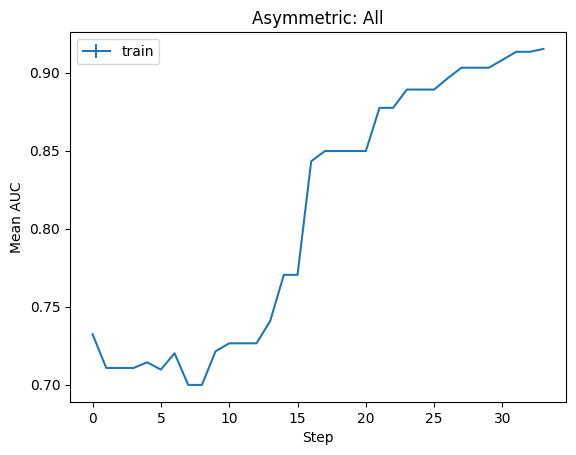

In [140]:
df = pd.read_csv(f'{experiment_dir}/BroadHoldoutEvals.csv')
# df = df.query("Run == 0 and Strategy == 'entropy'")
plot_auc(df[df['N_INIT']==0], title="Asymmetric: All")

In [41]:
!ls /raid/lingo/alexisro/lm-informants/results/batch/

all_features_log.csv   HoldoutEvals.csv
BroadHoldoutEvals.csv  ModelEvalLogs.csv
FeatureProbs.csv       prior_probabilities_of_test_set_items.csv
feature_query_log.csv  ResultsByObservations.csv


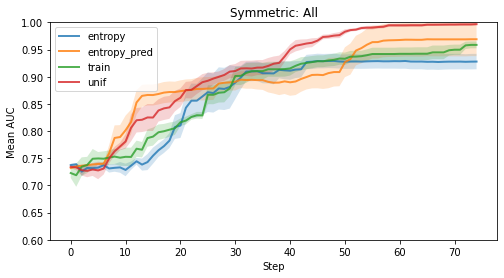

In [667]:
df = pd.read_csv('results/asymmetric_prior=0.2_ratio=2/BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

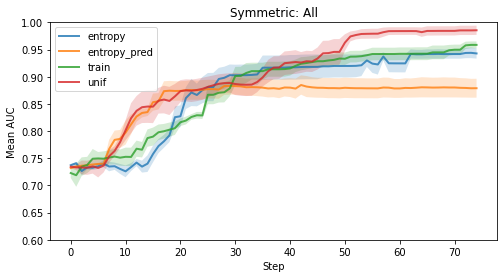

In [203]:
df = pd.read_csv('results/asymmetric_prior=0.2_ratio=3/BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

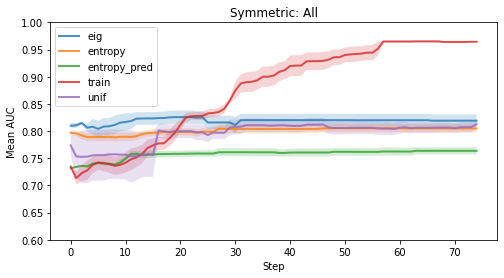

In [420]:
df = pd.read_csv('results/asymmetric_prior=0.2_ratio=45_one-step/BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

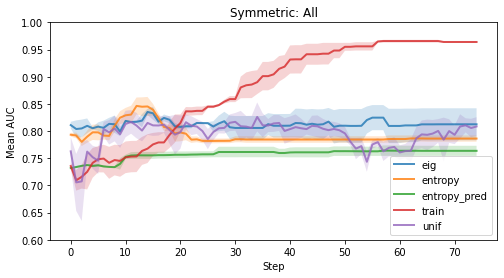

In [412]:
df = pd.read_csv('results/asymmetric_prior=0.2_ratio=500/BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

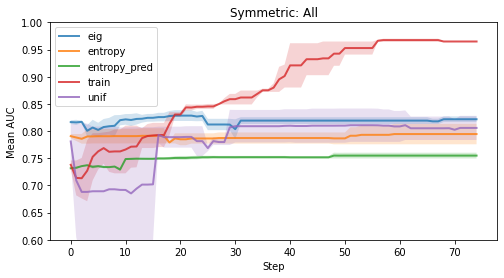

In [316]:
df = pd.read_csv('results/asymmetric_prior=0.2_ratio=45/BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

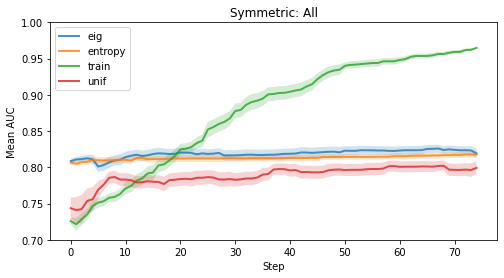

In [246]:
df = pd.read_csv('BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

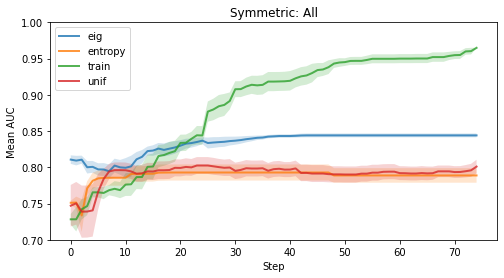

In [120]:
df = pd.read_csv('results/asymmetric_prior=0.01/BroadHoldOutEvals.csv')
# display(df)
plot_auc_fancy(df[df['N_INIT']==0], title="Symmetric: All")

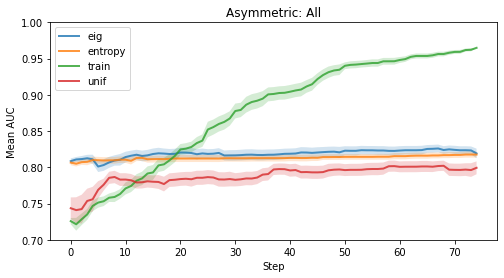

In [106]:
df = pd.read_csv('results/asymmetric/BroadHoldOutEvals.csv')
plot_auc_fancy(df[df['N_INIT']==0], title="Asymmetric: All")

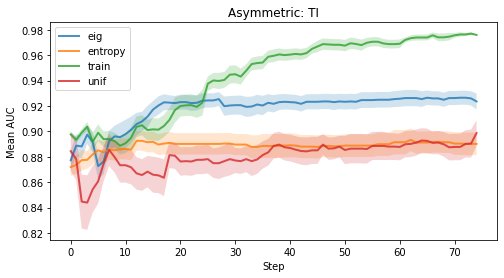

In [45]:
plot_auc_fancy(df[df['N_INIT']==0], TI_only=True, title="Asymmetric: TI")

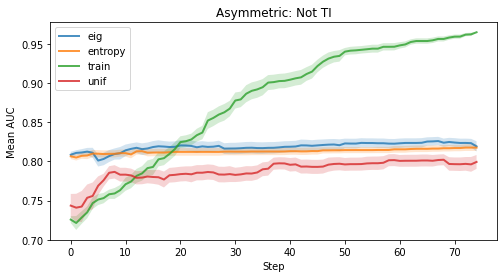

In [46]:
plot_auc_fancy(df[df['N_INIT']==0], TI_only=False, title="Asymmetric: Not TI")

/Users/alexisr/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/alexisr/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyError: 'train'

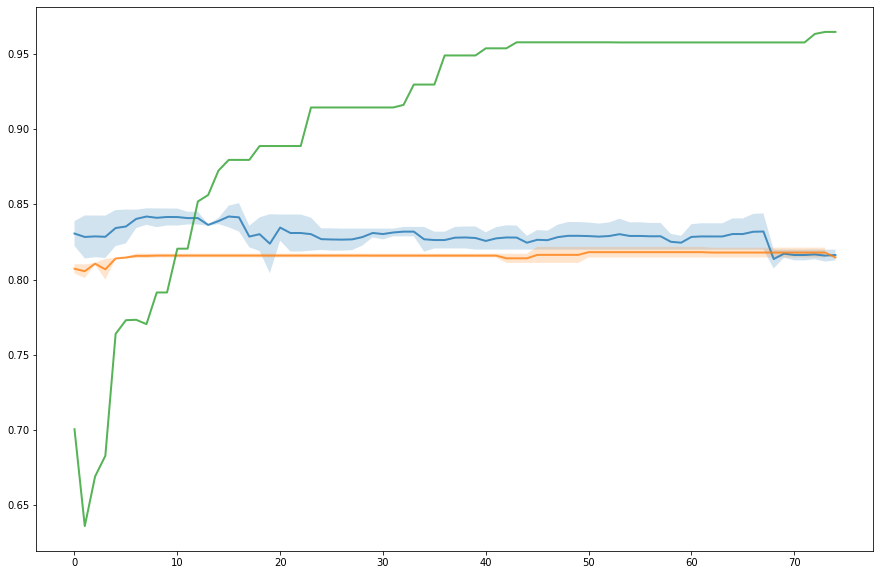

In [797]:
from scipy.stats import sem

# create a pivot table to calculate mean and standard deviation of auc by Step and Strategy
pivot_df = df.pivot_table(values='auc', index='Step', columns='Strategy', aggfunc=[np.mean, sem])

# get the mean auc and standard deviation values for each Strategy
means = pivot_df['mean']
stds = pivot_df['sem']

# set up the plot
plt.figure(figsize=(15, 10))

# plot the mean auc for each Strategy with shaded error bars
for col in means.columns:
    plt.plot(means.index, means[col], label=col, alpha=0.8, linewidth=2)
    plt.fill_between(means.index, means[col] - stds[col], means[col] + stds[col], alpha=0.2)

# set plot title and axis labels
plt.title('Mean AUC by Strategy')
plt.xlabel('Step')
plt.ylabel('Mean AUC')

# add legend and grid
plt.legend()

# display the plot
plt.show()

In [553]:
run = 0
step = 0
df.query(f"Strategy == 'eig' and Run == {run} and Step == {step}")

,Step,Run,Strategy,N_INIT,Items,Costs,IsLicit,Prob,auc


In [85]:
display(df)

,Step,Run,Strategy,N_INIT,Items,Costs,IsLicit
0,0,0,eig,0,"['ki pi qI tI', 'ta qI', 'ke pi ki', 'qE ta', ...","[324.91061089371846, 22.231526310942467, 146.9...","[False, True, True, True, False, False, True, ..."


In [8]:
import matplotlib.pyplot as plt

plt.plot(mean['Step'], mean['change_in_probs'])

KeyError: 'Step'